# Parametric Experiment!
#### Studying the affects of batch size on model accuracy.
- Batch Size will be parametrically varied, while other meta parameters are held constant.
- Model accuracy will be recorded to evaluate model performance and gauge the affect that batch size had on the model.

In [2157]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

In [2158]:
# importing wine dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url, sep=';')

#### Examining Dataset
- Will remove outliers and use Z-score normalization.

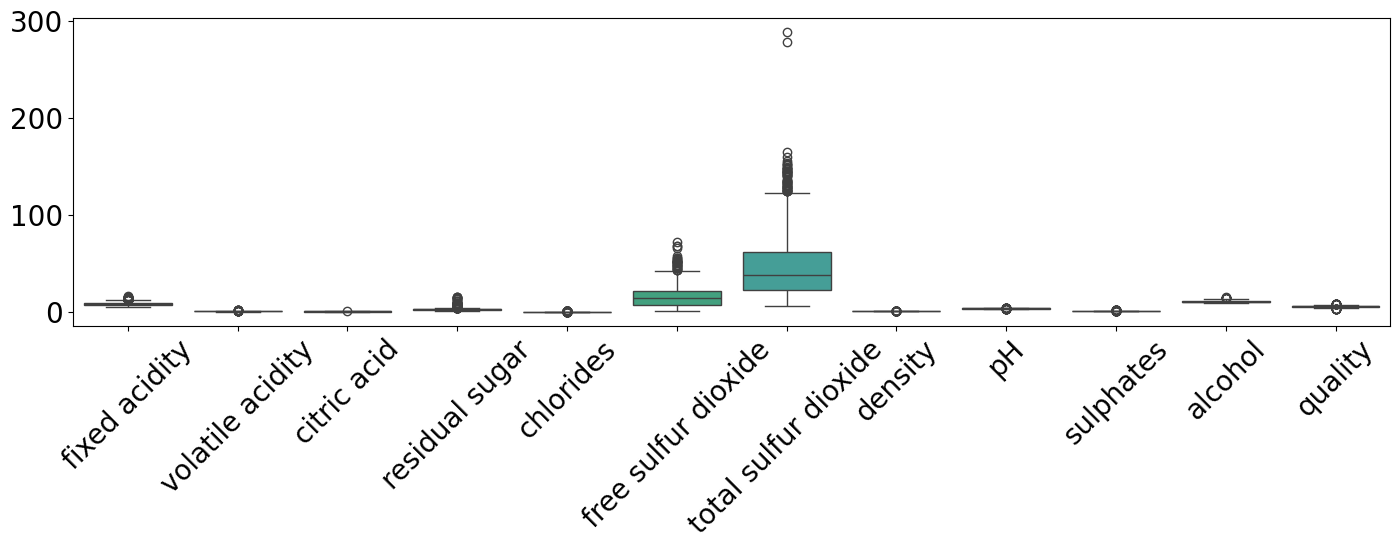

In [2159]:
# plotting unmodified data
fig, ax = plt.subplots(1, figsize=(17,4))
ax = sns.boxplot(data=data)
ax.tick_params(axis='x', rotation=45)
plt.show()

#### Removing outliers in `total sulfur dioxide` feature

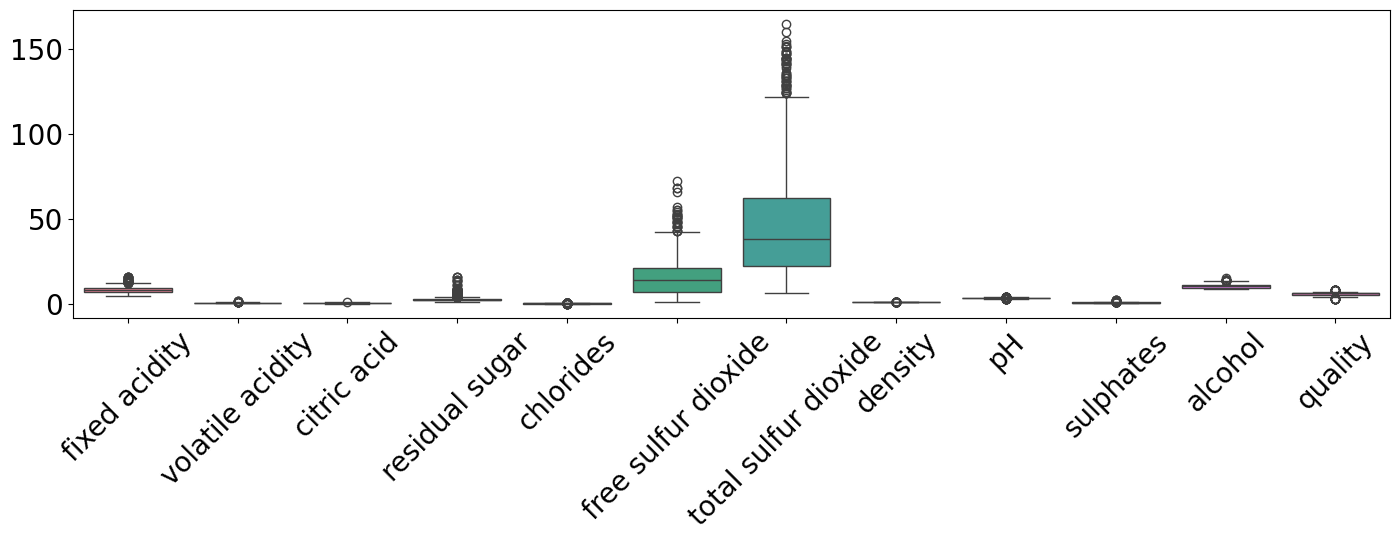

In [2160]:
# removing outliers
data = data.drop(data[(data['total sulfur dioxide']>200)].index) # finds indices of rows where total sulfur dioxide > 200 and drops them

# plotting data before Z-score normalization
fig, ax = plt.subplots(1, figsize=(17,4))
ax = sns.boxplot(data=data)
ax.tick_params(axis='x', rotation=45)
plt.show()

#### Applying Z-score Normalization to all features except `quality`.

In [2161]:
# selecting columns to normalize
selected_columns = data.keys()
selected_columns = selected_columns.drop('quality', 'bool_quality')

print(selected_columns)

data[selected_columns] = data[selected_columns].apply(stats.zscore)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


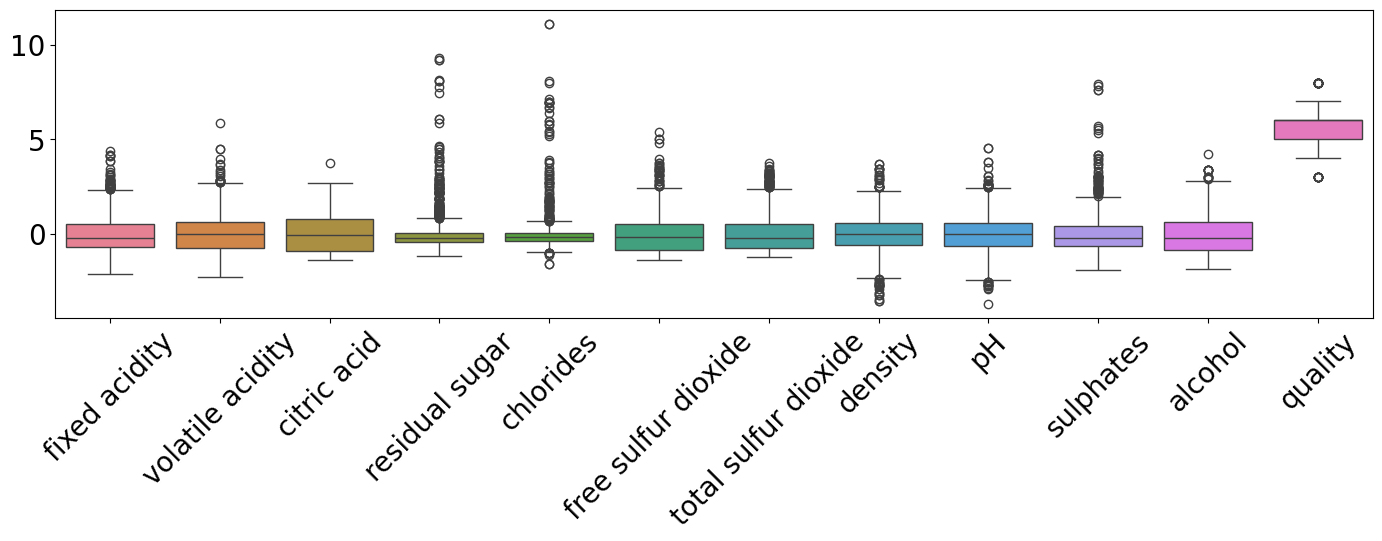

In [2162]:
# plotting normalized data
fig, ax = plt.subplots(1, figsize=(17,4))
ax = sns.boxplot(data=data)
ax.tick_params(axis='x', rotation=45)
plt.show()

### Distribution of Quality Values
- In an ideal situation, all of the quality values are equally distributed through the entire dataset.

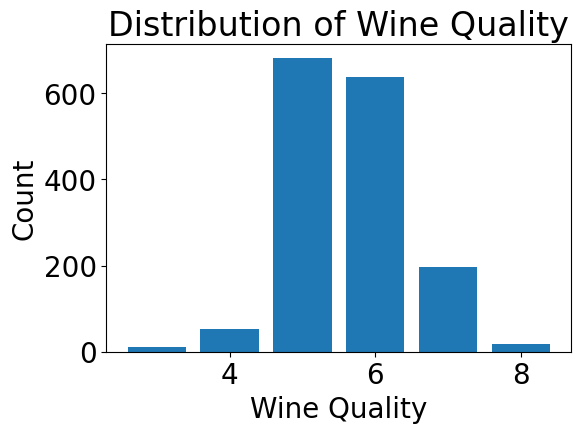

In [2163]:
# plotting distribution of quality values
fig = plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 20})

counts = data['quality'].value_counts()
plt.bar(list(counts.keys()), counts)
plt.xlabel('Wine Quality')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality')
plt.show()

### This is not an even distribution! Next steps.
- **Binary categories** - Instead of having categories where each wine is predicted to be a 3 - 8 quality, there will be `good` (ratings $\gt 5$) or `bad` (ratings $\le 5$) wine. 
    - This simplifies the problem, and the model required to solve it.
- In this dataset, the wine qualities at 5 and 6 are over-represented compared to the rest of the qualities.
- The binary categories will be labeled in a new feature created, called `bool_quality`.

In [2164]:
# creating a new column for boolean quality. Assigning 1 when rating is >5 in 'quality' feature, else 0.
print(data.keys())
data['bool_quality'] = 0
data['bool_quality'] = np.where(data['quality']>5, 1, 0)

# data[['quality', 'bool_quality']]

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


#### Loading Data

In [2165]:
# converting to tensors
print(selected_columns)

torch_data = torch.tensor(data[selected_columns].values).float() # excluding quality and bool_quality columns
labels = torch.tensor(data['bool_quality'].values).float() # binary quality values are used as the label for each wine

print(torch_data.shape)
print('labels array:',labels.shape)
print('labels:', labels)

# converting labels into a 1D tensor (from list)
labels = labels[:,None]
print('labels tensor:',labels.shape)
#print(labels)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')
torch.Size([1597, 11])
labels array: torch.Size([1597])
labels: tensor([0., 0., 0.,  ..., 1., 0., 1.])
labels tensor: torch.Size([1597, 1])


In [2166]:
# Partitioning Data into training and test sets
training_data, test_data, training_labels, test_labels = train_test_split(torch_data, labels, test_size=0.1)

# creating tensor datasets
training_data = TensorDataset(training_data, training_labels)
test_data = TensorDataset(test_data, test_labels)

#### The `create_data_loaders()` function will allow a data loader object to be created for each batch size.

In [2167]:
# creates data loaders with specified 2^N batch size
def create_data_loaders(training_dataset, testing_dataset, batch_size):    
    
    train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(testing_dataset, batch_size= testing_dataset.tensors[0].shape[0], shuffle=False)
    return train_loader, test_loader

---
## Model Architecture

In [2168]:
class ANN_wine(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input_layer = nn.Linear(11,12)

        # hidden layers
        self.hidden_layer_1 = nn.Linear(12,64)
        self.hidden_layer_2 = nn.Linear(64,64)

        # output layer
        self.output_layer = nn.Linear(64,1)

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer_1(x))
        x = F.relu(self.hidden_layer_2(x))

        return self.output_layer(x)

In [2169]:
# function to create model
def create_ANN_wine_model(learning_rate):
    model = ANN_wine()

    # loss function
    loss_function = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    return model, loss_function, optimizer

### Function to Train Model

In [2170]:
def batch_train_model(number_of_epochs, model, loss_function, optimizer, train_loader, test_loader):
    
    training_accuracy_ary = []
    testing_accuracy_ary = []
    losses_ary = torch.zeros(number_of_epochs)

    # loop over epochs
    for epoch_IDX in range(number_of_epochs):

        # enable training
        model.train()

        batch_accuracy = []
        batch_loss = []
        
        for batch, labels in train_loader:
        # forward pass and calculate loss
            y_hat = model(batch)
            #print('Size of y hat',y_hat.size())
            #print(y_hat)

            #print('labels size', labels.shape)
            #print(labels)
            loss = loss_function(y_hat, labels)

            # back propagation (learning)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate accuracy for current batch
            batch_accuracy.append(100*torch.mean(((y_hat >0) == labels).float()).item())

            # batch losses
            batch_loss.append(loss.item())

        # calculate overall training accuracy and loss
        training_accuracy_ary.append(np.mean(batch_accuracy))
        losses_ary[epoch_IDX] = np.mean(batch_loss)

        # disable training
        model.eval()

        # Cross Validation of Model
        X_data, y_labels = next(iter(test_loader)) # there is only one batch, so there's no need for a for loop
        
        with torch.no_grad(): # disables gradient-related computations, appropriate when testing model
            predicted_testing_labels = model(X_data)

        # calculate testing accuracy
        testing_accuracy_ary.append(100*torch.mean(((predicted_testing_labels>0) == y_labels).float()).item())

    return training_accuracy_ary, testing_accuracy_ary, losses_ary

#### Checking Models and Training

In [2171]:
# model params
learning_rate = 0.009
num_epochs = 1000
batch = 32

# creatining data loaders
train_ldr, test_ldr = create_data_loaders(training_data, test_data, batch_size=batch)

# creating and training model
test_model, test_loss, test_optimizer = create_ANN_wine_model(learning_rate)

training_acc_2, test_acc_2, losses_2 = batch_train_model(num_epochs, 
                                                   test_model, 
                                                   test_loss, 
                                                   test_optimizer, 
                                                   train_ldr, 
                                                   test_ldr)

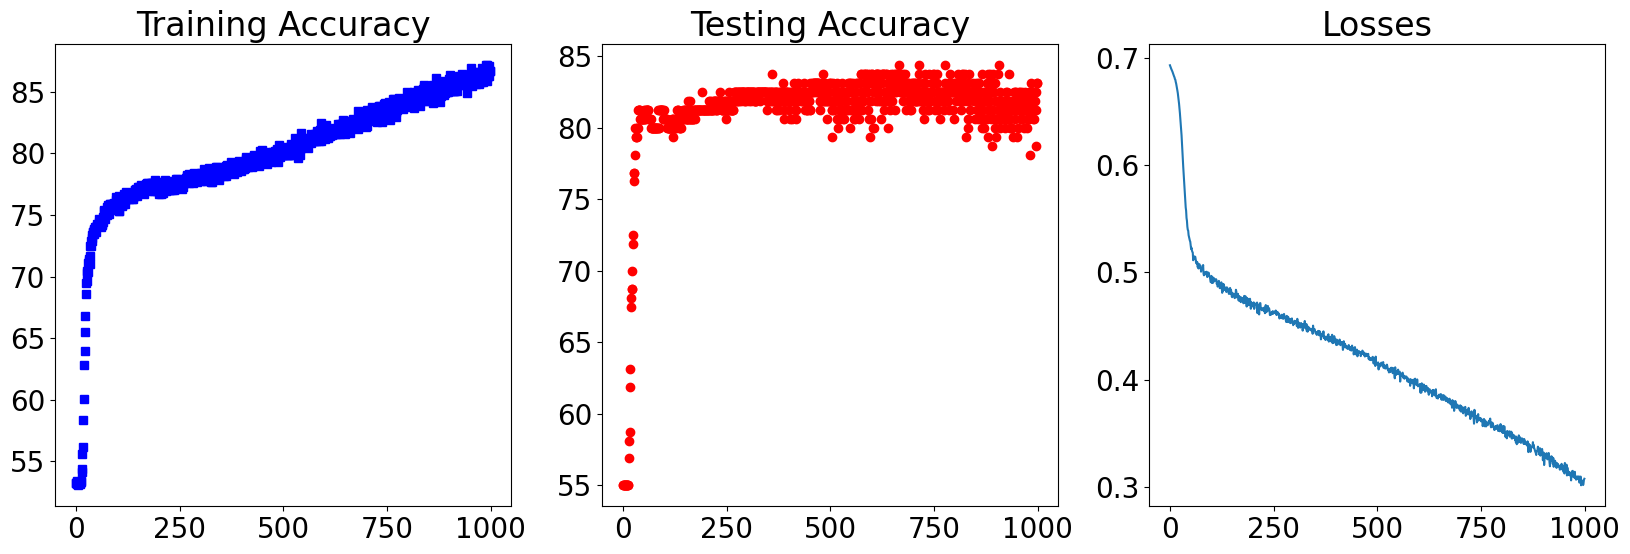

In [2172]:
# plot results
fig, ax = plt.subplots(1, 3, figsize = (20,6))

ax[0].plot(training_acc_2, 'bs')
ax[0].set_title('Training Accuracy')

ax[1].plot(test_acc_2, 'ro')
ax[1].set_title('Testing Accuracy')

ax[2].plot(losses_2)
ax[2].set_title('Losses')

plt.show()